# Slowly changing regression problem

In [1]:
import os
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0" # "1", "2", "3"

In [12]:
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial
from tqdm.notebook import tqdm
from flax.training.train_state import TrainState

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [5]:
path_base = "loss-of-plasticity/lop/slowly_changing_regression/data/env_data/scr/"
path_base = os.path.join("..", "..", "..", "external", path_base)
path_base

'../../../external/loss-of-plasticity/lop/slowly_changing_regression/data/env_data/scr/'

In [6]:
np.set_printoptions(linewidth=100)

### Config file
```python
{
  "model_version": "Generates the data",
  "_comment_1_": "List of problem/experiment parameters",
  "gen_prob_data": true,
  "num_runs": 100,
  "num_inputs": 20,
  "num_data_points": 10000000.0,
  "data_dir": "",
  "env_data_dir": "data/env_data/scr/",
  "flip_after": 10000,
  "num_target_features": 100,
  "num_flipping_bits": 15,
  "beta": 0.7,
  "_comment_2_": "Learner parameters",
  "agent": "bp",
  "num_features": 5,
  "hidden_activation": "relu",
  "opt": "sgd",
  "step_size": 0,
  "replacement_rate": 0,
  "decay_rate": 0,
  "env_file": "data/env_data/scr/0"
}
```

In [7]:
!ls -lah $path_base

total 13G
drwxrwxr-x 2 gerardoduran gerardoduran 4.0K Feb  7 14:38 .
drwxrwxr-x 3 gerardoduran gerardoduran 4.0K Feb  7 09:31 ..
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 09:58 0_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 10_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 11_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 12_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 13_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 14_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:38 15_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 13:08 1_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:36 2_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:36 3_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:37 4_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:37 5_py.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran 802M Feb  7 14:37 6_py.pkl
-rw-rw-

In [111]:
X.shape

(10010000, 20)

In [113]:
format(10010000, ",")

'10,010,000'

In [8]:
with open(os.path.join(path_base, "1_py.pkl"), "rb") as f:
    X, y = pickle.load(f)
X = jnp.array(X)
y = jnp.array(y)

X[:10]

Array([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]],      dtype=float32)

In [9]:
# B
step = 10_000
ix_select = [
    0, step - 1,
    step, 2 * step - 1,
    2 * step, 3 * step - 1
]
X[ix_select, :-5]

Array([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.]], dtype=float32)

## Evaluating runs

> we used Backprop in an incremental manner without any mini-batches.

In [88]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X).ravel()
    loss = jnp.power(y - yhat, 2).mean()
    return loss


class MLP(nn.Module):
    dim_out: int
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

loss_grad = jax.value_and_grad(lossfn, 0)

def train_epoch(state, xs, num_epochs=10):
    xt, yt = xs
    for _ in range(num_epochs):
        loss, grads = loss_grad(state.params, xt, yt, state.apply_fn)
        state = state.apply_gradients(grads=grads)
    return state, loss

In [107]:
%%time
files = os.listdir(path_base)
num_files = len(files)

losses_df = {}

num_epochs = 1
learning_rate = 0.01
model = MLP(1, activation=nn.relu)
partial_train = partial(train_epoch, num_epochs=num_epochs)

for t, file in tqdm(enumerate(files), total=num_files):
    file_path = os.path.join(path_base, file)
    print(f"Training {file}")
    with open(file_path, "rb") as f:
        key_init_t = jax.random.fold_in(key_init, t)
        X, y = pickle.load(f)
        X = jnp.array(X)
        y = jnp.array(y)


        shape_input = X[:1].shape
        batch = jnp.ones(shape_input)
        params_init = model.init(key_init_t, batch)

        state = TrainState.create(
            apply_fn=model.apply,
            params=params_init,
            tx=optax.adam(learning_rate)
        )


    xs = (X[:1_000_000], y[:1_000_000])
    state, hist_loss = jax.lax.scan(partial_train, state, xs)
    hist_loss = jax.block_until_ready(hist_loss)

    hist_loss = np.array(hist_loss)
    losses_df[t] = hist_loss
losses_df = pd.DataFrame(losses_df)

  0%|          | 0/16 [00:00<?, ?it/s]

Training 1_py.pkl
Training 9_py.pkl
Training 14_py.pkl
Training 12_py.pkl
Training 3_py.pkl
Training 11_py.pkl
Training 10_py.pkl
Training 2_py.pkl
Training 8_py.pkl
Training 0_py.pkl
Training 5_py.pkl
Training 4_py.pkl
Training 15_py.pkl
Training 7_py.pkl
Training 13_py.pkl
Training 6_py.pkl
CPU times: user 18.3 s, sys: 4.55 s, total: 22.8 s
Wall time: 1min 59s


In [108]:
indices = np.arange(1_000_000)

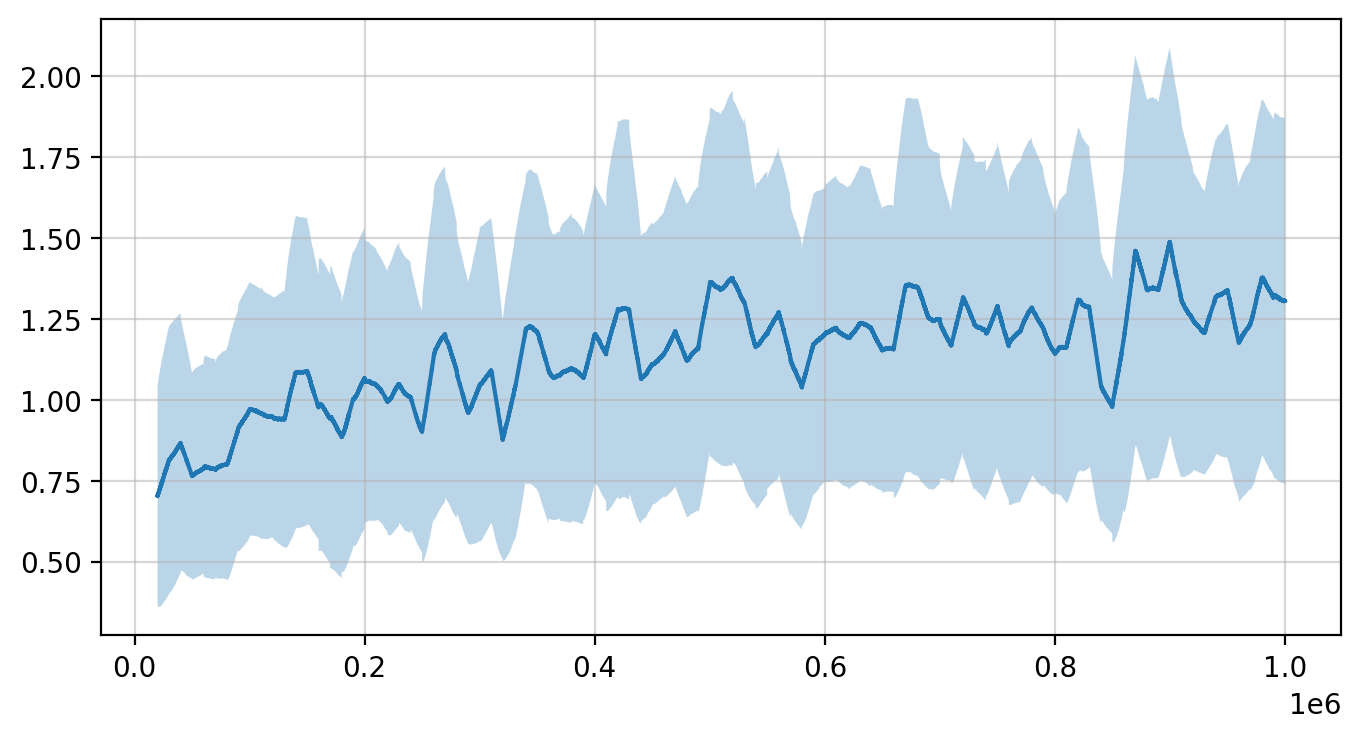

In [109]:
fig, ax = plt.subplots(figsize=(8, 4))
rolling = losses_df.mean(axis=1).rolling(20_000)
rolling_mean = rolling.mean()
rolling_std = rolling.std()

lbound = rolling_mean - rolling_std
ubound = rolling_mean + rolling_std

rolling_mean.plot(ax=ax)
plt.fill_between(indices, lbound, ubound, alpha=0.3)
plt.grid(alpha=0.5)

In [110]:
rolling_mean.iloc[-1]

1.3059595315277577

In [104]:
import subprocess
l = subprocess.run(["ls", "-l"])

total 3797100
-rw-rw-r-- 1 gerardoduran gerardoduran  470542477 Jan 30 11:14 1d-bnn.pkl
-rw-rw-r-- 1 gerardoduran gerardoduran    1701718 Jan 28 07:33 BBB-1d-regression.ipynb
-rw-rw-r-- 1 gerardoduran gerardoduran     944273 Jan 28 07:33 BBB-rmnist.ipynb
-rw-rw-r-- 1 gerardoduran gerardoduran    1660476 Jan 28 07:33 ORFit.ipynb
-rw-rw-r-- 1 gerardoduran gerardoduran          0 Jan 28 07:33 __init__.py
-rw-rw-r-- 1 gerardoduran gerardoduran     242448 Feb  6 12:13 animation-rotating-one-ensemble-360.mp4
-rw-rw-r-- 1 gerardoduran gerardoduran     222600 Feb  6 11:46 animation-rotating-one-ensemble.mp4
-rw-rw-r-- 1 gerardoduran gerardoduran     893903 Jan 30 18:40 bnn-incremental-hmc.ipynb
-rw-rw-r-- 1 gerardoduran gerardoduran    1315498 Feb  3 14:54 bnn-rmnist-hmc-trenches.ipynb
drwxrwxr-x 3 gerardoduran gerardoduran       4096 Jan 30 11:50 data
drwxrwxr-x 2 gerardoduran gerardoduran       4096 Jan 28 07:33 dekf_demos
-rw-rw-r-- 1 gerardoduran gerardoduran    1249374 Feb  7 13:53 ensemb